<a href="https://colab.research.google.com/github/NuriaAk/DataLearn/blob/DE-101/Cute_or_dangerous_spider_EN_RU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries and DuckDuckGo images API.

Загружаем библиотеки и DuckDuckGo для доступа к изображениям.

In [21]:
from fastai import *
!pip install  duckduckgo_search
from duckduckgo_search import DDGS
from fastcore.all import *

Creating a function that searches for an image using keywords / Создадим функцию, которая ищет изображение по ключевому слову(keyword).


NB! The function below relies on the duckduckgo.com which may not always return the right image / Функция загружает выдачу с сайта duckduckgo.com, которая не всегда релевантна ключевому слову.

In [58]:
def search_images(keywords, max_images=30):
    print(f"Searching for '{keywords}'")
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

Let's try to search of 1 image of "jumping spider" / Попробуем найти 1 изображениe паука-скакуна

In [59]:
urls = search_images('jumping spider', 1)
urls[0]

Searching for 'jumping spider'


<ipython-input-58-479929441ed1>:3: UserWarning: DDGS running in an async loop. This may cause errors. Use AsyncDDGS instead.
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


'https://www.thoughtco.com/thmb/PV_ODbCv6KGiP4qA4QDNRgfoXic=/2874x1881/filters:fill(auto,1)/GettyImages-175560551-5c6a7018c9e77c00012710f4.jpg'

Download the url and see a picture/ Загружаем изображение из url, которое мы получили выше

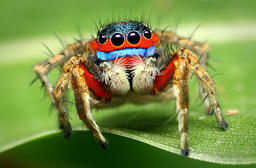

In [60]:
from fastdownload import download_url
dest = 'jumping_spider.jpg'
download_url(urls[0], dest, show_progress=False)

# Lets resize the image into a thumbnail / Уменьшаем изображение
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Let's do the same with a "red widow spider" / Давайте попробуем то же самое , но с пауком красная вдова

Searching for 'red widow spider'


<ipython-input-58-479929441ed1>:3: UserWarning: DDGS running in an async loop. This may cause errors. Use AsyncDDGS instead.
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


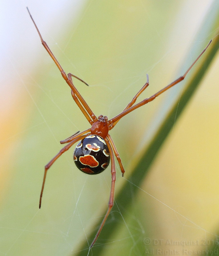

In [62]:
download_url(search_images('red widow spider', 1)[0], "red_widow_spider.jpg", show_progress=False)
Image.open('red_widow.jpg').to_thumb(256,256)

Results seem to be relevant. Let's download more and create 2 folders to save the images there / Результаты выдачи изображений соответствуют запросу. Давайте загрузим больше и сохраним в 2 папки

In [66]:
searches = 'red_widow', 'jumping'
path = Path('cute_or_dangerous')

# Let's add the sleeping timer, so our downloads wouldn't overload the duckduckgo.com servers
# Добавим таймер, чтобы загружать изображения с сайта с периодичностью и не перегружать сервера duckduckgo
from time import sleep

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents = True)
  download_images(dest, urls = search_images(f'{o} spider photo'))
  sleep(5)
  download_images(dest, urls = search_images(f'{o} spider day photo'))
  sleep(5)
  download_images(dest, urls = search_images(f'{o} spider night photo'))
  sleep(5)
  resize_images(path/o, max_size = 400, dest = path/o)


Searching for 'red_widow spider photo'


<ipython-input-58-479929441ed1>:3: UserWarning: DDGS running in an async loop. This may cause errors. Use AsyncDDGS instead.
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


Searching for 'red_widow spider day photo'
Searching for 'red_widow spider night photo'
Searching for 'jumping spider photo'
Searching for 'jumping spider day photo'
Searching for 'jumping spider night photo'


Let's remove the failed images/ Давайте удалим неудавшиеся загрузки

In [67]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

We are using `DataLoaders` to train a model.  `DataLoaders` is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a `DataBlock`, and view sample images from it.

Используем обьект `DataLoaders` для обучения модели. Используем настраиваемый обьект `DataBlock` для того, чтобы обозначить долю изображений , используемых для валидации (0.2) и 80% оставим для дообучения модели.

In [68]:
dls = DataBlock(
    # The inputs to our model are images, and the outputs are categories (in this case, "red_widow" or "jumping").
    # Вводные данные для нашей модели - изображения ImageBlock, а в результате получаем категории CategoryBlock ("red_widow" или "jumping", красная вдова или скакун)
    blocks = (ImageBlock, CategoryBlock),
    # To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).
    # Чтобы наша модель нашла все изображения , мы дадим ей список файлов с помощью get_image_files
    get_items = get_image_files,
    # Split the data into training and validation sets randomly, using 20% of the data for the validation set.
    # Случайным образом поделим все наши изображения на обучающие и валидирующие. 80% для обучения и 20% (0.2) оставим для проверки(валидации)
    splitter = RandomSplitter(valid_pct=0.2, seed = 42),
    #The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be red_widow or jumping).
    # Лейблы или ярлыки мы назначаем из того, в какой папке находятся изображения: красная вдова или скакун (red_widow or jumping)
    get_y = parent_label,
    # Resize the image by squishing it as opposite to cropping
    # Меняем размер изображения
    item_tfms = [Resize(192, method = 'squish')]
    ).dataloaders(path, bs = 32)

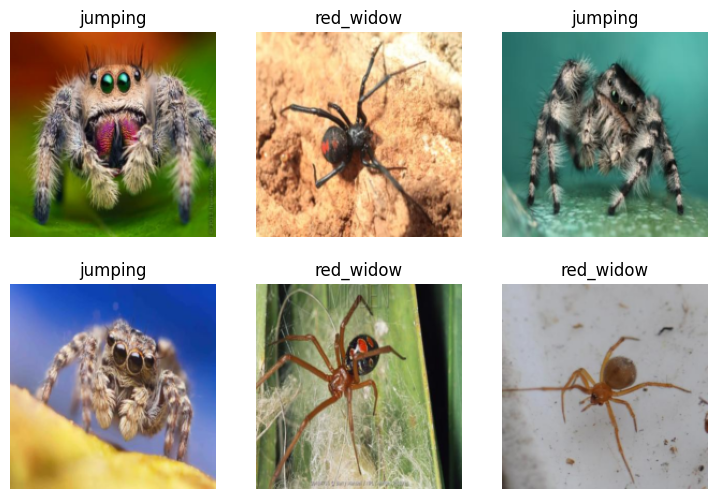

In [69]:
dls.show_batch(max_n = 6)

Now we're ready to train our model. The fastest widely used computer vision model is resnet18.

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.


 Теперь мы готовы обучить модель. Одна из самых быстрых моделей для компьютерного зрения это resnet18. fastai предоставляет метод fine_tune(), который автоматически использует лучший практики для дообучения уже натренированной модели.

In [70]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.108527,0.590139,0.233333,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.293419,0.124362,0.033333,00:23
1,0.254490,0.033690,0.000000,00:21
2,0.182265,0.037007,0.033333,00:22


Let's try our model on the first image of a jumping spider that we've downloaded in the beginning.
Давайте опробуем нашу модель на изображении самого первого паучка-скакуна, которого мы загрузили в начале

In [76]:
is_jumping_spider, _, probs = learn.predict(PILImage.create('red_widow_spider.jpg'))

# Порода паучка по версии нашей дообученной модели
print(f"This is a type of spider called: {is_jumping_spider}.")
# Уверенность нашей модели в том, что это паук-скакун низка, так как модель определила, что это красная вдова
print(f"Probability it's a 'jumping  spider' is {probs[0]:.4f}")

This is a type of spider called: red_widow.
Probability it's a 'jumping  spider' is 0.0000
